In [1]:
import os

import scipy
import tensorflow as tf
import numpy as np
import keras_cv
import keras
from matplotlib import pyplot as plt

# Useful article, from where we based our implementation:
# https://keras.io/examples/vision/yolov8

# Batching: The dataset is divided into smaller batches, each containing a fixed number of examples. The size of these batches is known as the "batch size".
BATCH_SIZE = 4

# The learning rate is a hyperparameter that controls the step size during the optimization process of training a machine learning model. It is a critical parameter because it influences how much the model's weights are updated in response to the calculated gradients during the training process. The learning rate is denoted by the symbol α (alpha) or sometimes referred to as the step size.
LEARNING_RATE = 0.001

# Number of complete passes through the entire training dataset during the training phase.
# TODO: Increase epochs and add callback to save model with the best mAP
EPOCH = 1

# Feature pyramid network (FPN) depth
FPN_DEPTH = 3

# Gradient norm clipping is a technique used in deep learning to prevent the exploding gradient problem and ensure more stable training.
# In the context of YOLO or object detection, where there is often a large number of parameters and complex interactions, applying gradient clipping on a global scale can be beneficial for training stability.
GLOBAL_CLIPNORM = 10.0

# Classes dict
class_mapping = {0: 'face'}


def load_and_preprocess_dataset(images_path, annotations_path):
    """
    Load and preprocess the data and return a tf dataset.
    The Dataset 
    
    :param images_path: Path to the images directory
    :param annotations_path: Path to the annotations file
    :return: TF Dataset
    """

    # Use SciPy tool to load .mat file with annotations
    mat = scipy.io.loadmat(annotations_path)
    # Read relevant information from annotations file
    event_list, file_list, face_bbx_list = mat['event_list'], mat['file_list'], mat['face_bbx_list']

    # Initialize intermediary lists
    image_paths = []
    bounding_boxes = []
    classes = []

    # Cycle over the event list (wider_face dataset is divided into events)
    for event_i, event in enumerate(event_list):
        event_name = event[0][0]

        # Cycle over all image files, and the respective bounding box lists
        for file, bbx in zip(file_list[event_i][0], face_bbx_list[event_i][0]):
            file_name = file[0][0]
            bbx = bbx[0].astype('int').tolist()

            bbx = list(filter(lambda b: b[2] > 30 and b[3] > 30, bbx))

            if len(bbx) == 0:
                continue

            # Get the complete image path 
            path = os.path.join(images_path, event_name, file_name + '.jpg')

            # Add image path to the intermediary list
            image_paths.append(path)

            # Add bounding boxes to the intermediary list e.g.:
            # bounding_boxes = [
            #    [[199.0, 19.0, 390.0, 401.0],
            #    [217.0, 15.0, 270.0, 157.0],
            #    [393.0, 18.0, 432.0, 162.0],
            #    [1.0, 15.0, 226.0, 276.0],
            #    [19.0, 95.0, 458.0, 443.0]],     #image 1 has 4 objects
            #    [[52.0, 117.0, 109.0, 177.0]],   #image 2 has 1 object
            #    [[88.0, 87.0, 235.0, 322.0],
            #    [113.0, 117.0, 218.0, 471.0]],   #image 3 has 2 objects
            # ...]
            bounding_boxes.append(bbx)

            # Add a list of zeros to the classes intermediary lists. There should be as many zeros as there are bounding boxes in the list. e.g.:
            # classes = [
            #    [0, 0, 0, 0, 0],      # 5 bounding boxes for the 1st image
            #    [0, 0, 0, 0],         # 4 bounding boxes for the 2nd image
            #    [0],                  # 1 bounding box for the 3rd image
            #    [0, 0],               # 2 bounding boxes for the 4th image
            # ...]
            classes.append(np.zeros(len(bbx)))

    # Convert lists to Ragged Tensors. The reason we're using Ragged Tensors instead of normal Tensors or NumPy arrays is because the dataset has a varying amount of bounding boxes for each image.
    bounding_boxes = tf.ragged.constant(bounding_boxes)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)

    # Construct Dataset from Tensors and return it.
    return tf.data.Dataset.from_tensor_slices((image_paths, classes, bounding_boxes))


def load_image(image_path):
    """
    Load JPEG image from path.
    
    :param image_path: Path to the image file.
    :return: Return image as NumPy array
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def prepare_data(image_path, classes, bbox):
    """
    Prepare data
    :param image_path: Path to the image file
    :param classes: List of classes
    :param bbox: List of bounding boxes
    :return: Dataset with appropriate format
    """

    # Load Image
    image = load_image(image_path)

    # Format the data
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


# Load and preprocess training dataset
print('Loading Training dataset...')
train_ds = load_and_preprocess_dataset(
    "resources/wider_face/WIDER_train/images",
    "resources/wider_face/wider_face_split/wider_face_train.mat"
)

# Load and preprocess validation dataset
print('Loading Validation dataset...')
val_ds = load_and_preprocess_dataset(
    "resources/wider_face/WIDER_val/images",
    "resources/wider_face/wider_face_split/wider_face_val.mat"
)

# Create Resizing Layer, to ensure all images have the same size.
resizing_layer = keras_cv.layers.Resizing(width=640, height=640, bounding_box_format="xywh", pad_to_aspect_ratio=True)

# Apply all the data preparation to the training dataset.
print('Preparing Training dataset...')
train_ds = train_ds.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(resizing_layer, num_parallel_calls=tf.data.AUTOTUNE)

# Apply all the data preparation to the validation dataset.
print('Preparing Validation dataset...')
val_ds = val_ds.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing_layer, num_parallel_calls=tf.data.AUTOTUNE)

# Apply all the data preparation to the test dataset.
print('Preparing Test dataset...')
test_ds = val_ds.shuffle(BATCH_SIZE * 4)
test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)


def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    """
    Use keras_cv utilities to visualize the Dataset.
    """

    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


Using TensorFlow backend
Loading Training dataset...


2024-01-28 12:20:59.419069: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-01-28 12:20:59.419089: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-28 12:20:59.419092: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-28 12:20:59.419131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-28 12:20:59.419145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loading Validation dataset...
Preparing Training dataset...
Preparing Validation dataset...
Preparing Test dataset...


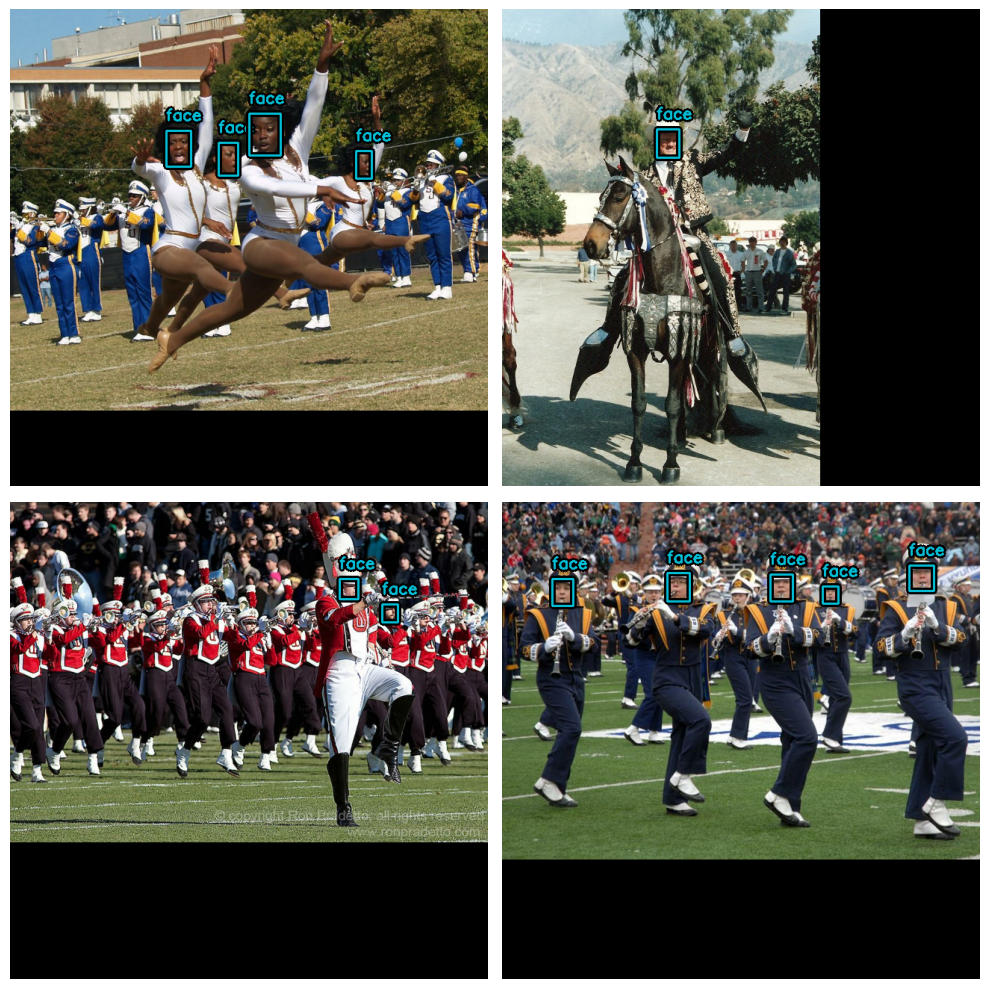

In [2]:
# Visualize first few images from training Dataset
visualize_dataset(train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2)

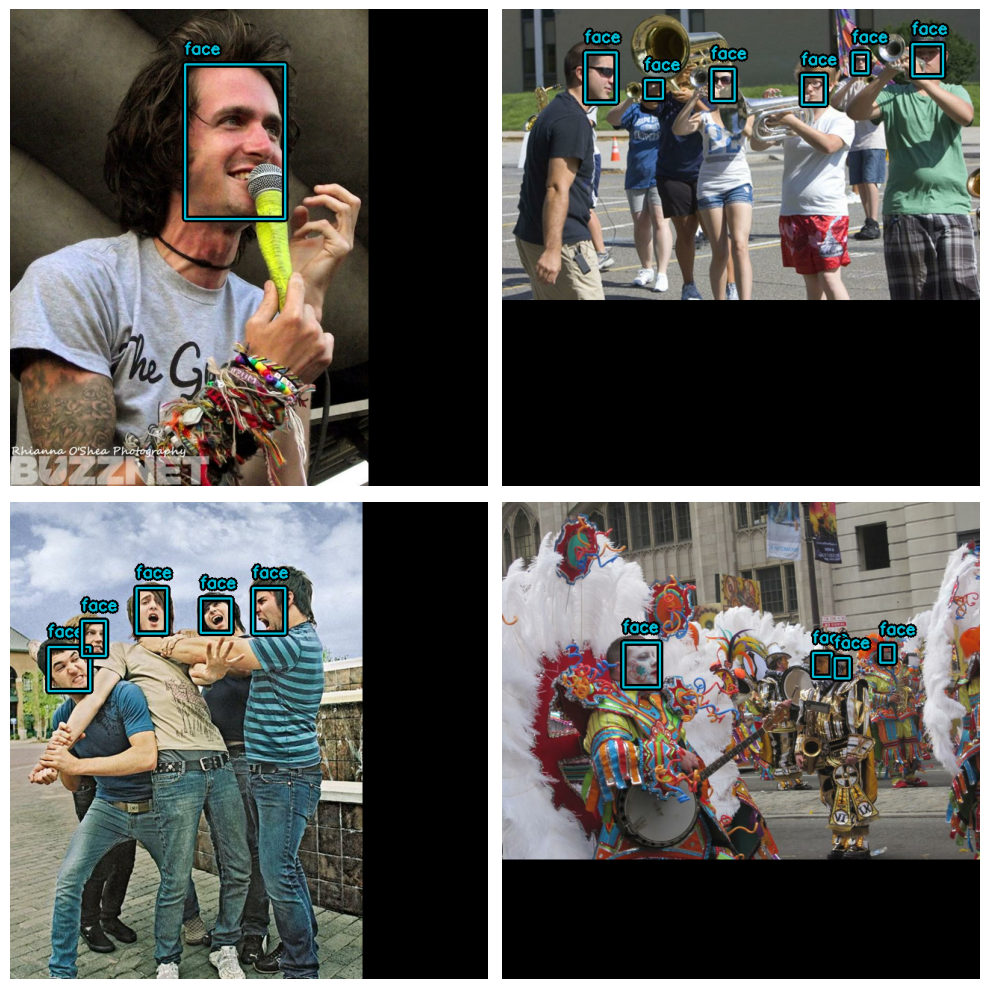

In [3]:
# Visualize first few images from validation Dataset
visualize_dataset(val_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2)

In [4]:
# First we will create an instance of backbone which will be used by our YOLOv8 detector class
# Info about YOLOv8: https://blog.roboflow.com/whats-new-in-yolov8/
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_m_backbone_coco"  # We will use YOLOv8 medium backbone with coco weights
)

# Next, we will build a YOLOV8 model using the YOLOV8Detector
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=FPN_DEPTH,
)

# Use Adam optimizer (using tf.keras.optimizers.legacy because it's recommended for running on a M2 Mac)
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

# Compile model.
# Loss used for YOLOV8:
#  Classification Loss: Binary Crossentropy
#  Box Loss: Complete IoU
print('Compiling Model...')
yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Compiling Model...


In [5]:
# Show a summary of the model
yolo.summary()

Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    1187246   ['input_2[0][0]']             
                             192),                        4                                       
                              'P4': (None, None, None,                                            
                             384),                                                                
                              'P5': (None, None, None,                                            
                             576)}                                                  

In [6]:
# TODO: Fix this Callback
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    """
    Callback to evaluate COCO metrics (mAP) on each complete training iteration, and save the best model.
    """

    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xywh",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [7]:
class BatchLossCallback(keras.callbacks.Callback):
    """
    Callback to save batch loss
    """
    
    batch_loss = []  # loss at given batch    
    batch_val_loss = []  # loss at given batch    

    def __init__(self):
        super(BatchLossCallback, self).__init__()

    def on_train_batch_end(self, batch, logs=None):
        BatchLossCallback.batch_loss.append(logs.get('loss'))
        BatchLossCallback.batch_val_loss.append(logs.get('val_loss'))

In [8]:
# Train model
print('Training Model...')
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    # callbacks=[EvaluateCOCOMetricsCallback(val_ds, "models/model.h5")], TODO: Use this Callback
    callbacks=[BatchLossCallback()]
)

# TODO: Test Model

Training Model...


2024-01-28 12:21:14.342963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-01-28 12:21:14.695107: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: RaggedSplit/assert_equal_3/Assert/AssertGuard/branch_executed/_9


2834/2834 [==============================] - ETA: 0s - loss: 10.6006 - box_loss: 2.4703 - class_loss: 8.1303

2024-01-28 16:47:30.124269: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: RaggedSplit/assert_equal_3/Assert/AssertGuard/branch_executed/_9


2834/2834 [==============================] - 16235s 6s/step - loss: 10.6006 - box_loss: 2.4703 - class_loss: 8.1303 - val_loss: 4.5018 - val_box_loss: 2.1882 - val_class_loss: 2.3136


1/1 [==============================] - 8s 8s/step


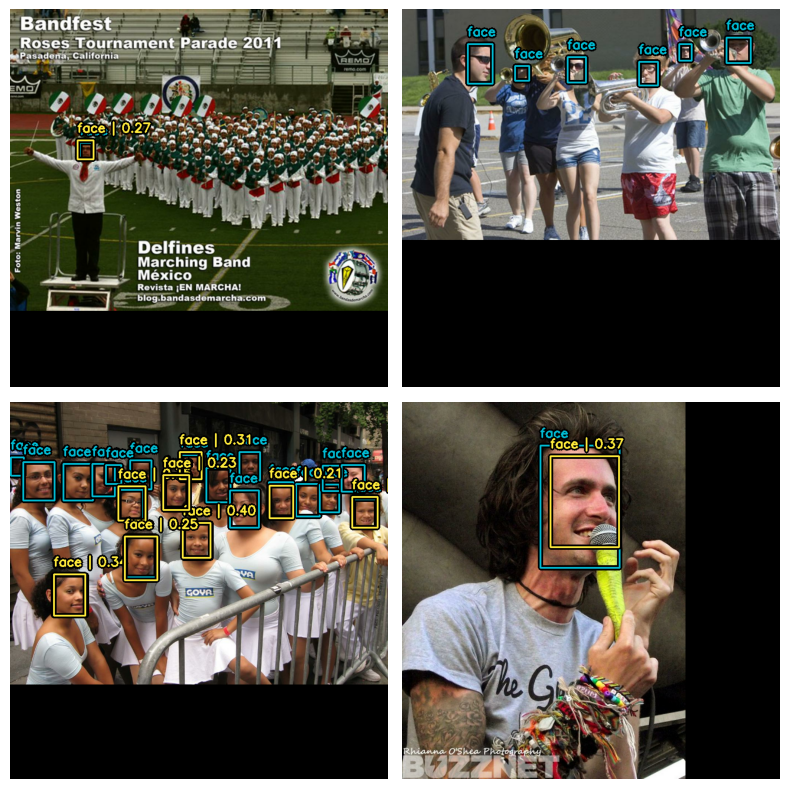

In [9]:
def visualize_detections(model, dataset, bounding_box_format):
    """
    Use keras_cv utilities to visualize the first few images with the ground truth bounding boxes and the predicted bounding boxes.
    
    :param model: The TF model
    :param dataset: Dataset to use for detection visualization
    :param bounding_box_format: Bounding box format
    """

    inputs = next(iter(dataset.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    y_pred = model.predict(images)
    y_pred = keras_cv.bounding_box.to_ragged(y_pred)
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=bounding_boxes,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


# Visualize first few predictions for the validation dataset
visualize_detections(yolo, dataset=val_ds, bounding_box_format="xywh")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: x and y must have same first dimension, but have shapes (1,) and (2834,)

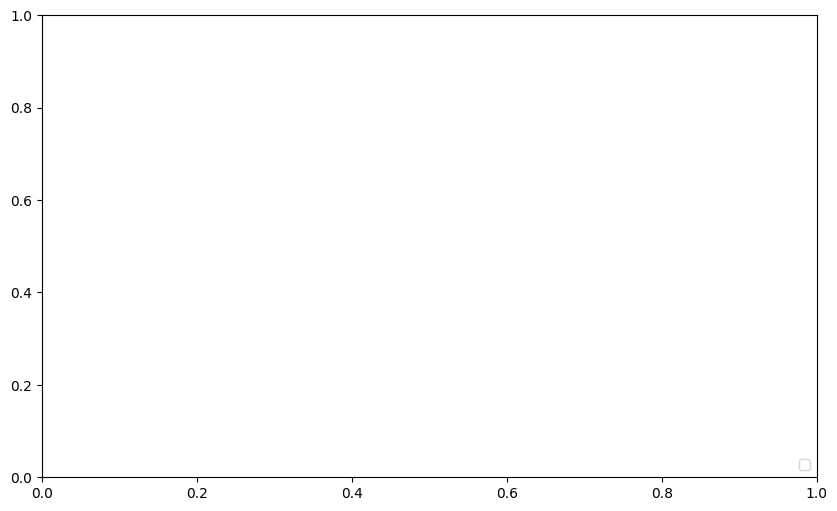

In [10]:
# TODO: Fix loss charts

# Evolution of loss
# loss = BatchLossCallback.batch_loss
# val_loss = BatchLossCallback.batch_val_loss
# epochs_range = range(EPOCH)
# plt.figure(1, figsize=(10, 6))
# plt.legend(loc='lower right')
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.show()

In [11]:
# TODO: Fix tests

# Evaluate Test dataset
# evaluation = yolo.evaluate(test_ds)
# print(f"Test Loss: {evaluation[0]}")
# print(f"Test Accuracy: {evaluation[1]}")

ValueError: in user code:

    File "/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras_cv/src/models/object_detection/yolo_v8/yolo_v8_detector.py", line 532, in test_step
        return super().test_step(*args, (x, y))
    File "/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "yolov8_detector" is incompatible with the layer: expected shape=(None, None, None, 3), found shape=(4, 4, 640, 640, 3)


In [12]:
# Save model in HDF5 file format (legacy)
yolo.save("models/face_detector.h5")

/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Save model in keras format
yolo.save("models/face_detector.keras")

/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [14]:
# Save model in saved_model format
yolo.save("models/face_detector")

/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/tiagonunes/PycharmProjects/computer-vision/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  re

INFO:tensorflow:Assets written to: models/face_detector/assets


INFO:tensorflow:Assets written to: models/face_detector/assets


In [15]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

#path of the directory where you want to save your model
frozen_out_path = 'models'
# name of the .pb file
frozen_graph_filename = "frozen_graph"

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: yolo(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(yolo.inputs[0].shape, yolo.inputs[0].dtype))

# Get frozen graph def
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pbtxt",
                  as_text=True)

2024-01-28 16:55:43.058671: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-01-28 16:55:43.058772: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-01-28 16:55:43.059505: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-28 16:55:43.059519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


------------------------------------------------------------
Frozen model layers: 
x
yolov8_detector/yolo_v8_head_1_box_2/beta
yolov8_detector/yolo_v8_head_1_box_1/beta
yolov8_detector/pa_fpn_p3p4p5_output/beta
yolov8_detector/pa_fpn_p3p4p5_pre_2_2/beta
yolov8_detector/pa_fpn_p3p4p5_pre_2_1/beta
yolov8_detector/pa_fpn_p3p4p5_pre_1_2/beta
yolov8_detector/pa_fpn_p3p4p5_pre_1_1/beta
yolov8_detector/pa_fpn_p3p4p5_pre_0_2/beta
yolov8_detector/pa_fpn_p3p4p5_pre_0_1/beta
yolov8_detector/tf.split_5/split/split_dim
yolov8_detector/pa_fpn_p3p4p5_pre/beta
yolov8_detector/pa_fpn_p4p5_output/beta
yolov8_detector/pa_fpn_p4p5_pre_2_2/beta
yolov8_detector/pa_fpn_p4p5_pre_2_1/beta
yolov8_detector/pa_fpn_p4p5_pre_1_2/beta
yolov8_detector/pa_fpn_p4p5_pre_1_1/beta
yolov8_detector/pa_fpn_p4p5_pre_0_2/beta
yolov8_detector/pa_fpn_p4p5_pre_0_1/beta
yolov8_detector/tf.split_4/split/split_dim
yolov8_detector/pa_fpn_p4p5_pre/beta
yolov8_detector/model/stack4_spp_fast_output/beta
yolov8_detector/model/stack4_spp_

'models/frozen_graph.pbtxt'